In [1]:
using DrWatson
@quickactivate "BNP2"
using Random, ProgressMeter, WeightsAndBiasLogger, MLDataUtils, BSON, Flux, Zygote
using MLToolkit.Neural, MLToolkit.DistributionsX
using Flux: Optimise
using Revise, BNP2

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/kai/.julia/packages/CUDAdrv/b1mvw/src/CUDAdrv.jl:67
┌ Info: Precompiling BNP2 [11504357-4fe5-5405-981c-8cd43ea31635]
└ @ Base loading.jl:1273


In [2]:
args = (
    seed        = 1110,
    dt          = 1f-1,
    n_trajs     = 10,
    is_noisyobs = false,
    σ_obs       = 1f-1,
)

;

In [21]:
include(srcdir("Data.jl"))
import .Data

data_cfg = Data.RandInitThreeBodyCfg(;
    ms = fill(5e10, 3),
    Q = cat(
        [-1,  0], 
        [ 1,  0], 
        [ 0, √3]; dims=2
    ),
    P = cat(
        [cos(π / 3), -sin(π / 3)], 
        [cos(π / 3),  sin(π / 3)], 
        [cos(π),      sin(π)]; dims=2
    ),
    n_init = 100, n_speed = 100, n_direction = 100, n_moving = 100, n_tests_per = 10,
    dt = args.dt, T = 50,
)

data_raw = Data.sim(MersenneTwister(args.seed), data_cfg)

for traj in data_raw.trajs_test[1:10:end]
    HTML(animof(traj).to_html5_video()) |> display
end

data = (
    train = Data.preprocess(data_raw.trajs; σ_obs=(args.is_noisyobs * args.σ_obs), is_paired=true), 
    test = Data.preprocess(data_raw.trajs_test; σ_obs=(args.is_noisyobs * args.σ_obs), is_paired=true),
)

@info "Processed data" length(data_raw.trajs) length(data_raw.trajs_test) size(data.train.s) size(data.test.s)

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABFgm1kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAB7lliIQAN//+9vD+BTY7mNCX\nEc3onTMfvxW4ujQ3vc4AAAMAAAMADuPlocG+vHIc0AAAWwAGWbfzhEj8xQEA3Pb/v+lXNWYbbzha\nP8HTLM8BUPuApGvNcN8OvybAGF/ib+T9uJjHIjTxX8hZA5hYBmNoA918asGfixHAfXI5t9LoH7Fd\nRWZsMv0ClOfISEp/Z3yUAMT9yljshg1PqGnjoBBHpIFOnuCGPodTUP27zVt9NNkjGs9NKx8Hwohq\nphzAAAEYHpXuEvyYGpb2/aWipe/7u1FOpbsnkUhTxjBJyZHzcXQGc8rYlvhcgUSuYMMNw0fWN91q\n82dN6kzOzLedmmsYItk11slsiZNEaqbDzw8g2d8cMuKpyzp+jn/jrK5NpjQV56rbjRyPJcImNLHb\nyEsaEIlpH0C3HxBjFlykb56gHtdpVrb6TaJG/ofndJG9SynwuTEqNy1mBJWIuN1zLTRuPSTfI4gg\n04E8RAOPPX7DfSJnq4GV3sNgBpyvY7diPfGLOZrfpM7fLlqAAAvYIWgxR0MNGxPBgBKtT0LTZT8I\n15ce/U3OqUchuOA1HJQX+hMfrKHmN1nheUdpl2mrYFWQjRgRqQMgljZYHAuH79FVO5N7M9T4P2+W\nx4/GyXS/2h6UdQhbj/ZI4iTBmz8ckaPAB6qb8UaCkEAAJPXP8POC1Ju4U9kd0+3qiKFbn6RIIBhU\nBUA/eQrs6QgPcXy76KjKLAAKceGRIgJ4wHk8tJbuWImZWhDRrRlJMcLxGx6cAm/dXKV6a6lhR6Qq\nqsq8d9Lw60vwTYR6evbUyp37G3VxOzdbrEPCEa+tOCEnOOZbtQlu8DasieA0gpc4+eTwOCB5tYve\nlK5xDu1IpdC8dDCCBmRqdTVNTf/G6JvzuSwzHHJyBlBPkFHa80of4LjdvBQAeA7ebtb/EMCqScTz\nfdlRi8fZqrjjvtSN2T9CZ6/C9w0R9sPuDMXASPb48xtipfnMlgcIbA+qNeE0MT/ZMwAAAwAAAwAP\nhSLGzzfxi76sLs6fPGHnLAMwnb4alovjW56oPu1QBRRRvhwlwnwoi4z8OeFQnNyFkxdO4K1QLs37\n2toJxWlCHZlGzJFmXkZ78zqYXqu8jM1UKqCktW9JumTxmVyDT1AqvHWhH7i/c4wnA9b5g0D9stLW\nzuHG4skocp+4idxqcIb4KviXjAvpH5RgbXtqdZ7J+nkAaBGvZfzMWBoa7+Ei5N9LvARtyG4iR0ud\nAlNVdog5sm3734ZK0MTPg/8Fq+cFp1HHmR8IozCvhAP6oLm6WF8Vefa7OP/KdBGBThK2XIUBSj7d\n8FQTjcxGjHmZ99rAfUq2SNzCWq8eM7oA1ao3I0e5Srfaznxmtxi7BBla8Lfd3hSnY7ovIdUGXXmG\ndx9yuw+4lCWcnWk3KfaZcN+jEiHciL2197GteajwiW1b1htBcc9MdOwg4K2jR0zlrgKsIrAWE2EJ\nM5i+lL72du78tLzRrH/KmKMkNq5tYNyryE8+A3mEY8GAg+ujJvA2k0L7wBvkrbPDWExK//9ctHAA\nHq3arSCOmdS21L/PybHoAAADAgdr0PSH6ZKUus5Fr9SXGL9Tdv5C7zvGJATCCI6PpfexgaQbfclO\nBRAHsywTlptydygJDNkDEO3kjxK7sFJMMNG/TI0Q7SKjI3YoF1LQAKNNrO1qhAPQjelSOYfxUiIi\nkfHs7iGvQCSLDBdDBEuxh/uFG5pNnQddADSBSS9m2Fq3yYlOePkKnSBLFkq+KGVGf1/dhVje4NkD\nVTL1CSXA6mnP22XJvfQf2pwrgALCDL+MVsvZ5h2JcIMBxFhsFQyi1PeDrS1/Rx3I45aZ2Dp8DIMJ\nrfj//yt1EJ/+9lISxJ/MoP8a5HgDeLDRf8OnczFpbozVKZ6ZirDZxMU9OTTYSrApf0i6zMRWeMAq\nK8dGzkiMv2D40/oc6WfnO84LTpyUD8gp0aNxH44VdPbHd8ua5KT65/D/x1Yh7izGTahA8uECj7Qt\nyEHBQ8Xj7K3zav8uV0wFxzVUVsoFCT8NNKM6xDvYTeeAAD/dkgRzuQImFid/XzT1oWY6wxAjw8/b\n+iUKh3uCjdomGTDW6EtPyJIwb4Y0S1o/h4gJeDYcj8c+lDikFV9t9OqxcCHBlqhoM42qqa3R3R6i\nVmoSehi3ptqKCVEzpTgbBmtWAWeN04jvjEt9CYdv8NubeNnBqYXhk7ns3echlCmMZPJefxC9/B75\nruGTBfb5CyMQDE+x28HuDae7b4MQ5E7UrmE9xiiSFZJx1ygdUUx8Ujsrxzmm/DNO+TmP2uK5y2i0\nQIN3oyMieFDCp7X158ZKIYrsgYP9S2Ww83grfrTzDsOiKNMgyZAV68+gDK8FFlLHG1JZn/Ag383m\nORlaUyvPQhh/TCBDZfKI0BTiHcGgbmsXSDecZoMvH0BChC5LEfBCNa6epvNQsf+H9B7onVbweef6\nd3QApcRIhdZpbxnUO7iOYxbq/eaQCCCOcDGBLbQQkbClvFxa5JhRMrp/mKhvG5qZ5HhzhJNHdrfq\nQhIHARD2xyswbUqjo6iHOXwuaaJGN9i21V8nWCC7xwXZycgxtrrxzqyVQTXFj6tGhzmNbC99yhqo\ni0EzeN4OOhGH9vfBRUFI7eAAAAMARcEAAAGbQZohbEN//qeEAAKOJ5oBja4/QiSMub5fekJb9+hL\n9fJNfseF/ufgLujVc39iGC39cucmB98TilT8fbWSwo8EkMdTULNNXsPjpleSv0pp479puHtsFn61\nXldc9LiPNQfQS08SVmk+xJGHYekeH07lK0JHfSmF1+BJ2S

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAm6m1kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAACUBliIQAN//+9vD+BTY7mNCX\nEc3onTMfvxW4ujQ3vc4AAAMAAAMADuPlocG+vHIc0AAAWwAGWbfzhEj8xQEA3Pb/v95jiX87sMS2\nZoJWY9un2QhQjDyyuk7jc4khdvroEeZyk0B/X6NKr+aDMgHQGoVPqccgLqoCMD2p5DL/2IVA+CTQ\n1cg/oIMl8vSgIm+ce731UL804+4x7tgz4bgp+RIzM6fAAAH6GY/sWAc9SIJWLIyPToBc7FEFGWVw\nZdkZyEx8aN/PIexIYvOgKdkfM8DblN0mxJRTI8C+UCjzn09b5qg/753PcEG/21P6y0+pCVRgX1AP\n9Mx+4XGf2jKhPVcmZH+i3kiKfXI8TxmPzlaaOyS2ZwgvE7LKOhEWsQacLEdak07dsCOlHGuWcXfO\nxrR6uNmjAWvDmOfxf4kBv8zkTvnSj919btzfu8pEJZxWS+jy9L/KGYrG7/O3xo9P5noL1/Wmijia\nbGmn+JyGw6RQdbu4eyDU/H240KJh/nbU8w3lCMwWDDATj9xant0o/VpG2qNMa+Uo8wQplhXZqi5w\nYYHhv9kCi6JV4AxqQeNFCEjR1yc5Y9loL2RkZ6pSkhmGWISAtbllvrOIaJ1ST6y+MLk5rJwhAV2Z\n/+vy0R4/d+w7GKPYZgacqa4ArA0+Ms/LvKDwu/GZzeQ3+R/q4ltCCViOCLZLUGwiLQH1sSgiDuZ+\nG00ccBjTspVIDDMJD/vMscY2yRoGJXa4C6X4DAMlLhlJfBNWsBnERB1HjDVBh2+mo/zKq8Uh0dG6\nfPf4hmriD3P3NG6E0F5m583VUa8C8JTNq/QpxWqI1fI4fPZN+BARovsHR1QM+R15aXAxyHSarpu9\nIpTQSWnXCh6y8SAo7KuQk9cr30ljt13uHDy4X23ccNxxfR7/F8Z2ygglCXOPq61+d0CEZ/VDa/rz\nP1cCSNwbW8hRHEj1M35JhMT+m67BSw/7L1WsyLpyCFREzQxARDC697IvtIABREC7OFKT2ap+qq7o\ng895G54WRTIS+SWQSHESpsTTMtIjpPDD1hZiKThr+yq0h27794BKHa8v3172yAGXk2lPl++G9Tdw\nbBc91B8MuvehWVoBj3ivTPeSFwqs5kPLoFWKWnzphG5bPkvn9AUKRMVZnEQxxxR5/5d/maUtD1Kn\nGoeO1KRpTR+6yf3C2DT35i5pHUUfs4nXVXUobhr0HikO9zOMWqSGEjOuFV3PKZkvmztBc9/UU8+5\naZtVkyXou2I/A2UrycJFNSf83WBAS6KJn4ANAe4JMgqZHpfN9pNfEfcZMB5XKUJvInICppX0uOH6\nq2ZWuTunrvdYIXugPf9v/gvu1N6lJITl1QDGxUuGmMR+pJJBqTrtoH9FsoqC8u4g1c3ZfEjmjr+h\nAeTpudbxzLtYZhJiIHfXB55nvXeq+Gsq4jkH9KLPi6ZWNYK/XwzvCmsSMkz7NwbaUlJl26l9AFeh\n2lIxZ9TghadbC7dIFMonwJFQsNFQKlrmd54H4nihBj6R08E2zDv5NMW0bMIKf4jD3LWi0rT5SsHg\nFGNyEgAQkoEfZh8zGcnN1QLVnuv7dluviAABnGn1iCWE99Gbe0KenKsqXCYZyQxvOYXd1+jq6/b3\nipy7NJfSfOXKnXwwIdtVryr6DE5phHGM64AIK3nz8ShrksrNf+Gu+adCB2jzPuL6Sg9O19jnMgcl\nTLbLEBTOZG4CYY5S7RvkNHK1NoI52kF85BgA2AajkrYktvSaMFAKIQ5JuxK69qFGTEvjTNyY36UH\nMIkxfDe0BH5vTMRrtvnxT6IMXnDck/dgIHkSuDE1NErzFSSNEmkY+dMHX+FaDIatv0na/AsFUDai\n/8oveOeDbVBptTECPJHPI93tuFyOkp7BgCbFJg6FdBF8jNZD1OvSLgVSXK3GpRoXP3rbYwiG9vRC\nweuQbwDV01wvGMXEV3ojBLfGPU2zkMDBXgmv8ODc2S1ksNotS1Uqg95JqswrPp7PNkBcbex8irQs\nHhi9W6dh1+KIqDwj/Blg29FxzyNtuSK74kjdB4gU/nJEUpMVEOMfiCrq1UY0yyKWDeiluBgr5bHY\nPmOMKvty0yh0Bpa6Q4asiY9l7K+FpLFfjKvlpizhF8zqrQ7DY5vOr6/3kyy57ho9xaCcGNzPoY14\nBmfshv3bHUL3Pk+ZhFOzdRIDQ+Dk2y/aSuzrD38PCBKCgaQEaFizGTwN6o+P5Ypz18TVnBVNfFET\nhYTXKxhpP+Jirs/UsAnyjnNGLsXE0BVCbOB64bJKo3yyTXQs9pXI0ceRVSaLhtLelUh31xrjNvs0\n6r2BHddHVctF5TPgudZP99iR2yYqjtZlwaILXbitWR6FO8JwABG9BL4PIiDeN+3rfP54yCj0nhKW\n5JdLd08GXp/Kmosjw+UwqwxKxM3SjYqjtnygzFX3nxcdD6DAfJMnxn9Nu3+ljg9OrjZUbUWcv48p\nvPcb0SI9F3HV6Uq4pso3C2k/SqUc3YomRoeBDkFB+tpiEBCxQIxXD26QUQwBPHzKH65YjN1AbCS+\nLYIGEC7mBeafSclbiX9gMm3ZwM/imKCp/PTGcC0u5WRY9oYBSznuJBUzXDKXVUwxVeSnyjKNvkht\nxpK4nHyAoIXSt1vazDDGECYss6yWolLHs0Yrrw7eWujyhR9pDD1umbcILVKCZDrRmPIJOtZK5Zc6\nMzICLOoGCLGR3FIyJoHcu04yuLqQCH+Bf5jS2hkJfnFI3zJXZGHQw+E2ezYWE+fVCSZ8+oG/RCCA\n6IjhldvSlsyB6U46Jq30k0V+dYxd/MPdeYerwflkmyWUY5

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABUj21kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEItliIQAN//+9vD+BTY7mNCX\nEc3onTMfvxW4ujQ3vc4AAAMAAAMADuPlocG+vHIc0AAAWwAGhwH6+fzPmA2FzCfBr3Ruy2mjv+E2\nX+Vb6n3tMGSB+YeJ0x81i6Qd6IvP2dlhTyCzs/vMcPvaWcJJZFNeXF9Q2AmL9142gSXLjxiRDz/4\nkf/gMQzzW1DgrGSy7Z6/BjJzMKbwbte5wmTj1jAvzYGIwOOnStWOMbn/mZHoihwIVpXGHgaRBsRh\nX5yStcU/iuMEayEnPq5PjJ7iKn6YqtayhHQnpu2f6x+AKGHkmGM1bv6NKr+TUymIb7Dznl2l0NwQ\nJegngJqMLL9OLgf50aGrkIQYLddfxbdeLqsix8q3cz1/DD/e5pDsLnOldDiugsdA0vQ8zjNSw/zP\n/nW/tNw/w3fOoShO+kQwt5QAdiSyJzYOuHAOU8R2SGLUKiXh6vWz7j7bkAHZ9I89888eGS/yvqt7\n3kJ9e+7KvqHMNoilrV1fvCP4oRnD+pzllLD5Fp2ttOAO8e2Lw/zDn/+5+YLN37eEAAADALyq5uH2\nXrwqyeUmjSZwhc0Uk/nuApsVyIL5t0ZetcGVXSOWYck8f48yA/mYitXMIrQhpqsNbYlKOXgWQZEZ\nfVX4Qk4OgHM+ovm0Ng2qvvWf/54gEQmDl1WBIXHZDM9tKL5jn7XseCA8enR04h2fqB2xku9nZh8o\nJN78s7jc7oYSWODY6OOPtcTDRcqMgGxwLG9BoFYB6QPuqH25AWqL3tftXINO+OgFarL3UKXFv/hP\nhYGmBJGmfY+iuoJtPKC8VE1qXYYgMtJ0WWnkFHXtiMtdvhuDIP+toCyhImewk92MmYXd/qcl6vx3\n+WXTCFuyl90heiDOOTXiG4hmvuyKmwh5htmklGOGhWdAt3lGItqow6Yvssr8+nbbpVh0w7aQd0fd\nbUr/MqpQSIdv5Kiq7Ih4N9mpgfoidZvjQmGVcdPYoGBTqVYhXQuqVsPANzj2TbEYLnWd6QIS3265\n264UTCqjTeScteik/e5wNWOuGw0bvEAQJypLD0N4Vkh24Hfg3Wuwzse/nHi1UzXt0F0ZdyjSPUCH\nB0ywqBdN3Ar/tZTS6Ks68K+JkUlkRV193ECTnZ1tXvlN8q9sx8B2DP5vPKCeLrgHDscABuOD1iTA\n7fvKQKyAzSXrWXg93dmJnEElut40NozDvHDyFwdUd5i5Z7SknjPMw1hYOom91FDc/xWzedYEHJAb\ntv7WHNUQdNVGblNs7YywWwLGmbHb9SWoaj6d0tkRu3LgPoTd3MnvUOextqdeah/ldyOC8Vt/3n6+\nSecKs82AoJ5OxyL5VxXPn1CtOyLyPitZ8fNhepp2U31f7Ece1OlNba09nYwLcgBmeor9rDjWxJP6\nbnKEEIucHZgy6MHcCQPdJzEmA3pfRfwAKTjLPnIz63Ov/pkveJtfhZa9FaiLhbrMZuRXxLoVIpfX\nwlVS028sScQsLjVymyQ95ccQDpoJvKMkCXRAM8kUymOpqAyMzYiq5Q5Owc3ip5BsxiVVipynSg/3\n06H60DU07+2Xunuic9XzACaDvm/mX9SHYvdNqB6Y9vK8/8qsCMi462Jyq1222xcmwYV5+nqYI4WT\nX0yh4qGFpA+PW/4SKhlqz++BFksBv8dwqGx59SWENuAto+byhHfVrUXzsnjz8oOWkgc89t5kU6Fb\nqNgF6s8pswNGTuy1wR1i0aLNoWX+Wzj/C1AE65nUaYNw0YVTneopERrj/2R4vNyO8nuxONx9EHyV\nnqQ5pjgdi5QtHgJpMSOkxc1mzB2gekUM7eXySgt4DSQvusy6LFgXpvNU+mb5+/MppKHX/XFoJo7v\ngfqoU2HcrvMyyQITwY17eDWZ90t4BmOIZn7QjzqvN60OOym1u/89Wez/GpRzcxSZmVZXza/XWKXp\ndPY3u7mdRiGbt32s5O3D81GH6SBUjU1Pha9faKFVqoLvNNtPu4fBH5sHTZcRZ5m9wrv0QT01tL4y\nUqk52YAHgxnttU2k7f575aEp7I66oEdmwoTcZLGdPvhIjN4aHjzblLh0ZTkqL7ENGLC3FSFlFIL3\nxgV+tiP9ZSifzibsBXY27XGgoil7gz/j9Ioh/HcKplWmoHu+6U7Bu5WeU71koG1yNE+5AVp+a/Wm\nlqu8HhKQWujAnoGwO1GIZfn4VlH0uBCoVVq3AARQFQHmzv/lCgv3Ym5dups9ID8t2Xd+gVhjaq+d\nTQRhlEUZIa4RP9Wgl4GGs+4xSSw7uy+jXxcQ/XWRzab2K9SD760+LqX6PdYQ+zRkifiYtw8yR2a5\nGltJvWIYGplYgfOQD4nx6SuT3FiQFI+1unEKfsGS0Fu4+SQOC7sFYTS9X5ZTClju8XPXC7N9AgFI\nC1HFP6h5QRA0ZSLeWBCmjO7AAHOV4Uueu0IBUslNe/DNxrOPdtH/Ov8OT45STPejlsX+bI7LI+rh\nFTu7P2y1+wt9hbrSsGBlc8jtIqrp8FqLuodp0wvieOy6Ag5llUbpJFKoMmVGTcGSntr9EQ72zryG\n/UhSQwls+WpgLhVuG5JOIcZybJ7D3yuyt1Zrtw65eGXh3SlQnatSW1YlozskTbsX6/46/K3saAqO\nBCPliz/UL3oKe3cTHz6OcwhuHFyGPCwsl+3qKmX/e4mJEy9sFznLeZmr8KH4jbPH92JnPyNrVUv7\nKpRouJoelmHbxIm4PbvGzUDqIMhdPSqDrErCxjdJJDNlRVKlhDzXN4xG4ylKSuamG3o9/iEQVy/J\nIQ7mYRpy3wxzkGdobusIt23i6GsAOzN5r/1AARBnnvxbaU

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAyYW1kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAACzhliIQAN//+9vD+BTY7mNCX\nEc3onTMfvxW4ujQ3vc4AAAMAAAMADuPlocG+vHIc0AAAWwAGWbfzhEj8xQEA3Pb/v+qjWh1FcM5N\nvNtoldBWfBQ852W3WYbPACiuOJLUv5aevoX0/XDH75Ad/NG9xFgX0yiJnq+uRzb6eQZiL1rZFr+0\nuD/+S+qBBx+vDYBNqTMZ/bU8DuwrpEo/YVZ2Qwakc8g/n9jWJskHosd9wwM5Hj/OqJsLbB0AzDPx\n9osSKq/qCeZzokd98DWxjgCSXKdpJjbofmn9TSEhMW2wFHDNR7SZ/nO/vWqkQVe0JiMRpePE5tAS\np3eKm5i1t0yyQfwj8osM1mcDgEJFyeXw/s3iDNzNnwUTLOeJ0r/AwjHf/BvrEh98wLeeEQeWsIsG\nJb0bKWyCwNKhIimfUCTVekpRwSx2H/tnPXvZKNtgniuEIACOYtHcA/SpRLvgUEDEWRdydgwJ/u6j\nSeRhDh4lzUTm9VQmjNd6pGycn6BiSHNBistlI2PHeAySgAAjglNk6ycGQOb+gddjRRQTp2iXAhqR\nk2ZAvfXAzmu4KpIoQVrKpKFAwScCTAcgn+TirKD3tMfQCI1Yc1uCu7oKxs0VvYjJVLspZCHdBLbr\ndcdT5uATsutNww6uHn9R+ngsEuxpS8EvhrSr5G9G2BBd5Ckma1Z2NJ54CI35tjeK7OGblrWUyfj2\nOV+6bW7OrlKu8/T23AXiXsht5r0ZAkG8zXSd2o6xzqdZP9AQ9dC7QftbB+eqi1/DMr/I0s7gMmTn\n19T9IOi1tXUYb/A075n/v5vJsR7J3cj5V0kAMLvWKzJEeuvArXp9xOehEOv3/LBPlssWqqj962Lh\nlTFG4ouFQTOsTDNInbLonHR0tvIR0xEXdOYZSpR53cXtETmX+Rn93IuICjVX6dEDnZ7NvbaY8hHF\n6xoBsq+xRl1zdKaI7yAAKOA3TH4ngpvRWDQtrm2EQqGBWhD2BxKj91qtCiUPyDUZAYyQKnEKtbJz\nwBExVf2zkIoqR6BpBo78dTyUvtEE4VDH0+Cd/AQcFsGhpbiXDmQbkUGfTUSK7nUstCQcqs7eYepS\nNDUaC/0tEa1sCLu1j1hE+jSSzmbLgD+dZCv5ro5/F/JLI7NKgLBBz9sb5hYuKVC1xK5knUYzJtFs\ns9dZpsUT6zEjaLFIFIsbJJ3TS76tdINzImArvmQhWnbkeaMLvZlY8Nva/hqb52OHeDRi4hpvEpYq\nfKft9N2WtMoC9JagB4BWhQ5Pogqds18pGV/9fzFV+fn42QvfBfGqsFZJe1aXJIw4TGN5f7CKOKyE\nesKVW0cUogkrusRyMcVq+qv6Hmnadw+iM+HNm3+e7PVeSLbBqSgAIDRxU30TURH90u+9vfEcvtU4\nRR1U2A657HWBOUHG4kcub+AxwkJRcaWhU+edeTTFI8Rjy4jx72nD/xluUcEUtxixq+jAvOJ8XzAL\nQNwCfDqCwFE3lYXFn2w7D/FOPHffY7RKAArFri9+Tv7iDEhqPydVncWkSTT+jggtIaRcS1N64xwA\nJdiL60/tIMVvAAC6ZF7PltAmJxf9sf6iYoAxjJ2rdR9aBKYAKmaycci5YdnHQgSIdnRwTZj2hyVZ\nHe7iYaT0CqLJ5qoyImnPaUQw7ISWJmEzFaKGbQq6cdsRZ1BQiFif/Y1xAEZ0gflPxe7Wxtu8xIKh\nHXYAo3cDYHQfsBeOPecsr4cjNdziE8TZDLpYvGVOUvY9FdEwcte0+gXD5CSlh4zg1C/cT8SoTnBn\nBqgEysgtFyrD1ofRX3ETE2KFeSOwvtEhPkK2cUYPzA5FS+1zQdSHzAKeClvzP+kKAAecLTsbzl0U\ne3wtQm4FxJ+bFB6m2t92tVWODlxPON/edsiNCRQqIfMd0sAAAAMAGJVEXuVwV8rUeGr/P/uVVKXW\n/6JavVuwiqBAuSgsRisqCdJgJojcT6WWfxPHOhfsMAN+i/RMk+Ts3L0Mnz5t9T5m4ot+jnsZQVc5\n8+oLRSlRmySvaSDUnXa0scCu0awZW4avjVAa+qKRJvHcoNXbrSfn0zQn2BjPA4don1Z743ApF9Ue\njyvzSVhmbVi9MfT54fUW/+jNu+H9d8WGUZpf9Dmjs5xsYqX/cpebp435rNe9BFA9qTuFLRJjSE1j\nJhpO2hQhbj/Q83u/gP0wecbmI0nARFjNaO9p/gr0FDDV6PHfxkXtxxM9uAoAVySrT0aPX1o928nM\nieMpmwaUa9I9SQ1HYAAAAwAAAwN0/1hxCjOSS2JQMhcimIU1l5IN94VP2Tb6SJg6aWyaZ/YQK2Fr\nufQt2S9M1zZTDKV2sbH/YqDyYSsPkyI5oyKFkRH5jmDbqj7wSXekO4rAd7LkjHRRUBywDd8/vHX/\nnRTJi97eVXJAAs+YSWGFRMVK3v+65wRkgC+kB9/YTpUp9GtQ/xJP/PHUBtdFl2Uk/N+O1lqABVT0\nRMIiEccpCjN9LUn6kPaVw3I2L6f9lqORcQ3adulO6gM8f5JVoD40m7i6VUVJZ+gPZznjeBEUGRru\ncCtlmKTelkrIde28dMHbq08EUkkhSRtXdqsntDLb3lUQEDRDyrv2MbTw9QrhHYNhqad9gArRCT8N\nwLPo6BgeXIGAAAADAAAj5Kf7oGvq+8ZedxSPMXoc+wZygUf41Wbr8qR0jKxU9uTQPY0BZaZJ0Pxt\n0bWuv7BfN5saovKXu4HOVt6CW5wA2DtkhggUqzqmwk7qmUWIxk8TYcp5hfbruu/NfmH5HVbw+/1A\nDAk6F6F6opmBJoyyMTFYfNf1LLKKv/3k4o6z/GMfsMBOhe

┌ Info: Processed data
│   length(data_raw.trajs) = 400
│   length(data_raw.trajs_test) = 40
│   size(data.train.s) = (4, 3, 50, 400)
│   size(data.test.s) = (4, 3, 50, 40)
└ @ Main In[21]:31


(loss = 26.115963f0, loglikelihood = -26.115963f0)

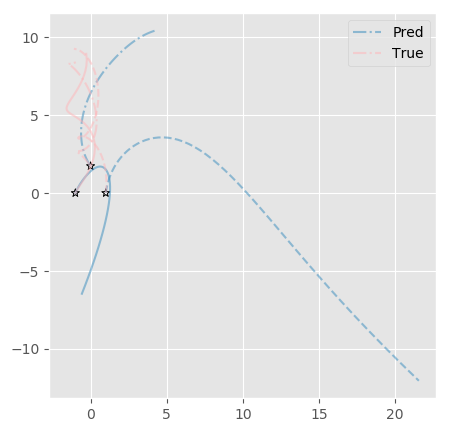

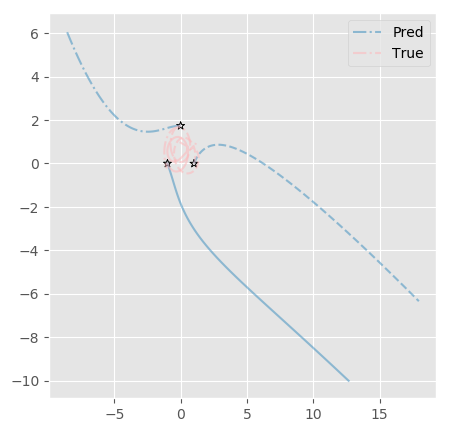

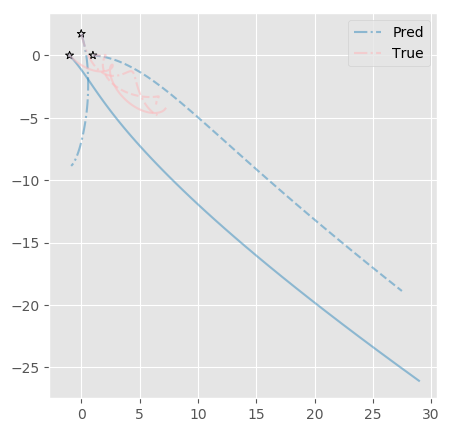

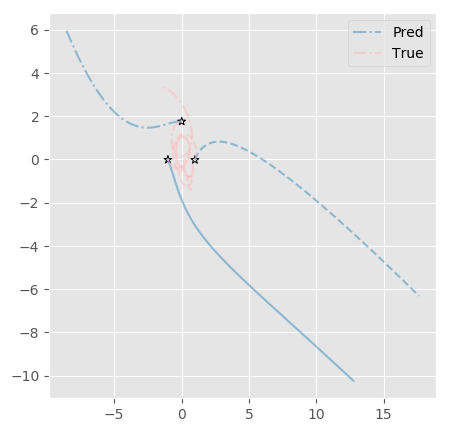

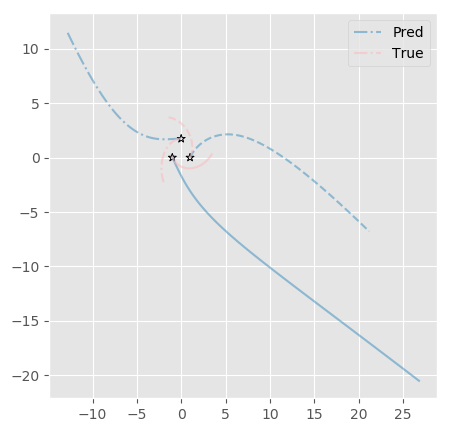

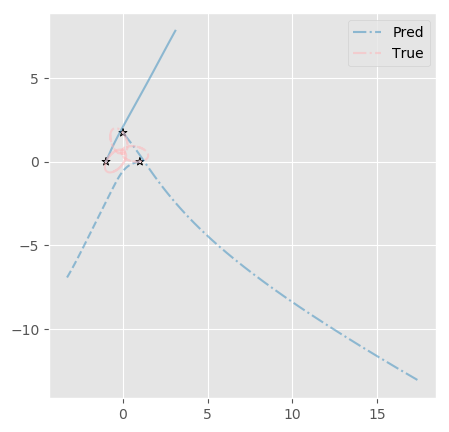

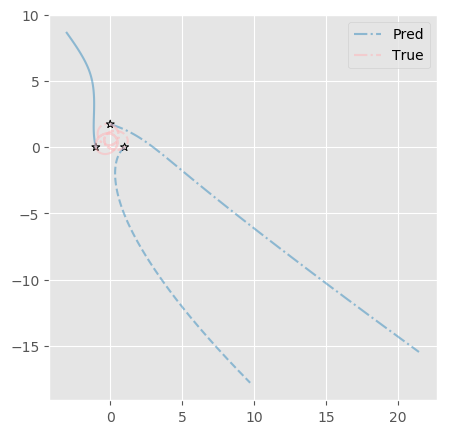

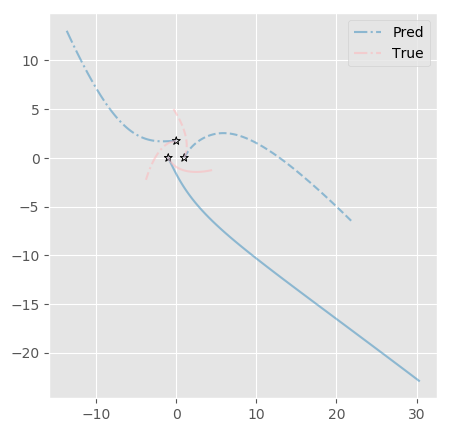

┌ Info: Main.Models.NeuralRelation{Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},DenseNet,Float32,Array{Float32,1}}(Dense(4, 50), DenseNet(Chain(Dense(100, 100), #30, Dense(100, 100), #30, Dense(100, 2))), 0.1f0, Float32[0.1])
└ @ Main In[23]:59


In [23]:
include(srcdir("Models.jl"))
import .Models
Zygote.refresh()

function predict(m::Models.DeepTransition, env, T)
    function envfrom(state)
        dim = div(size(state, 1), 2)
        return Space(Particle.(fill(5e10, 3), state[1:dim], state[dim+1:end]))
    end
    state = Vector{Float32}(vec(stateof(env)))
    traj = [envfrom(state)]
    for t in 1:T
        state = Models.transit(m, state)
        push!(traj, envfrom(state))
    end
    return traj
end

function predict(m, env, T)
    s = stateof(env)
    d, n = size(s, 2), size(s, 3)
    function envfrom(state)
        return Space(Particle.(fill(5e10, n), [state[1:d,i] for i in 1:n], [state[d+1:2d,i] for i in 1:n]))
    end
    state = Matrix{Float32}(cat(s[1,:,:], s[2,:,:]; dims=1))
    traj = [envfrom(state)]
    for t in 1:T
        state = Models.transit(m, state)
        push!(traj, envfrom(state))
    end
    return traj
end

function vis(
        m, trajs, T_ext::Int=0; 
        lws=["-", "--", "-."], fst=(color="black", marker="*")
)
    info = Dict()
    for (i, traj) in enumerate(trajs)
        traj_pred = predict(m, first(traj), length(traj) + T_ext - 1)
        
        fig, ax = figure(figsize=(5, 5))
        
        h1, = plot!(ax, traj_pred; lws=lws, first=fst)
        h2, = plot!(ax, traj; c=COLORS[:pink], lws=lws, first=fst)
        ax.legend([h1, h2], ["Pred", "True"], loc="upper right")
        
        info[Symbol("trajs[$i]")] = fig
    end
    return info
end

make_paired(batch) = tuple(batch[:,:,1:end-1,:], batch[:,:,2:end,:])

# model = Models.DeepTransition((100, 100, 100), args.σ_obs)
# model = Models.NeuralForce((100, 100, 100), args.dt, args.σ_obs)
# model = Models.NeuralBodyForce(50, (100, 100), args.dt, args.σ_obs)
model = Models.NeuralRelation(50, (100, 100), args.dt, args.σ_obs)
@info model

using Test

function test_estforce(model)
    x1 = rand(2 * 2, 1, 5)
    x2 = rand(2 * 2, 1, 5)
    x3 = x1
    x = cat(x1, x2, x3; dims=2)
    f = Models.estforce(model, x)
    @test f[:,1,:] == f[:,3,:]
end

let model=model, batch=data.train[:,1:10]
    test_estforce(model)
#     @code_warntype model(batch...)
    model(batch...) |> display
    gradient(params(model)) do
        model(batch...).loss
    end
    
    info = vis(model, data_raw.trajs_test[1:5:end])
    for fig in values(info)
        display(fig)
    end
end

;

In [24]:
logger = WBLogger(project=projectname(), notes="")
config!(logger, args)


wandb: Waiting for W&B process to finish, PID 27856
wandb: Program ended successfully.
wandb: Run summary:
wandb:                 _step 1391
wandb:   train/loglikelihood -124.16047668457031
wandb:              _runtime 1508.0139691829681
wandb:            train/loss 124.16047668457031
wandb:            _timestamp 1584044003.070394
wandb:   valid/loglikelihood -84.99446868896484
wandb:            valid/loss 84.99446868896484
wandb: Syncing 8 W&B file(s) and 256 media file(s)
wandb:                                                                                
wandb: Synced chocolate-frog-119: https://app.wandb.ai/xukai92/BNP2/runs/kz5jf913
wandb: Tracking run with wandb version 0.8.27
wandb: Wandb version 0.8.29 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Run data is saved locally in wandb/run-20200312_202351-oprx2so5
wandb: Syncing run blooming-silence-120
wandb: ⭐️ View project at https://app.wandb.ai/xukai92/BNP2
wandb: 🚀 View run at https://

In [ ]:
let model=model, ps=params(model), n_epochs=200, opt=Optimise.ADAM(5f-4), batch_size=10
    with(logger) do
        @showprogress for epoch in 1:n_epochs
            for (iter, batch) in enumerate(eachbatch(values(shuffle(data.train)); size=batch_size))
                local info
                gs = gradient(ps) do
                    info = model(batch...)
                    info.loss
                end
                @info "train" info...
                Optimise.update!(opt, ps, gs)
            end
            @info "valid" model(data.test...)... vis(model, data_raw.trajs_test[1:5:end])...
        end
    end
    
    bson(datadir("$(split(string(typeof(model).name), ".")[end]).bson"), model=model)
end

;

In [ ]:
let model=model, traj_true=data_raw.trajs_test[21], T=length(traj_true)-1, T_ext=20
    traj = predict(model, first(traj_true), T + T_ext)
    HTML(animof(traj, traj_true).to_html5_video()) |> display
end

;

## MCMC

In [ ]:
@model three_body(ms, states, dt) = begin
    q ~ MvNormal(zeros(6), 10)
    p ~ MvNormal(zeros(6), 10)
    space = Space(Particle.(ms, q, p))
    for i in 1:length(states)
        space = transition(space, dt)
        states[i] ~ MvNormal(vec(stateof(space)), 1e-1)
    end
end

@time chn = sample(three_body(massof.(data.objs0), data.states, args.dt), args.alg, args.n_samples)

splot(chn; colordim=:parameter) |> display

bson(datadir("three_body-noise=$(args.σ).bson"), chn=chn)

;

let n_mc = 50, T = 100, do_mean = true, res = get(chn[end-n_mc+1:end], [:q, :p])
    Q = Matrix{Float64}(hcat(res.q...)')
    P = Matrix{Float64}(hcat(res.p...)')
    if do_mean
        Q = mean(Q; dims=2)
        P = mean(P; dims=2)
    end
    Q̂ = zeros(6, T)
    for i in 1:size(Q, 2)
        q, p = Q[:,i], P[:,i]
        space = Space(Particle.(data.ms, q, p))
        traj = simulate(space, args.dt, T)
        Q̂ = Q̂ + hcat(positionof.(traj)...)
    end
    Q̂ = Q̂ / size(Q, 2)
    HTML(animof(Q̂).to_html5_video()) |> display
end

;